# 📊 Campaign Diagnostics: Segment Performance & Cost Simulation

This notebook analyzes client features to uncover actionable insights for improving marketing efficiency and reducing costs. It includes:

- Conversion and cost metrics per segment
- Statistical tests to validate differences
- Visualizations
- Cost simulation analysis


## Import Liraries and load data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# Style
sns.set(style="whitegrid")

In [ ]:
# Step 1: Download and unzip

!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip -o bank-additional.zip

# Step 2: Load the FULL dataset

df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2025-06-14 17:21:51--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank-additional.zip’

bank-additional.zip     [  <=>               ] 434.15K  1.42MB/s    in 0.3s    

2025-06-14 17:21:52 (1.42 MB/s) - ‘bank-additional.zip’ saved [444572]

Archive:  bank-additional.zip
   creating: bank-additional/
  inflating: bank-additional/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/bank-additional/
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: __MACOSX/._bank-additional  


In [ ]:
# Convert target to binary
df['y'] = df['y'].map({'yes': 1, 'no': 0})

In [ ]:
cost_per_call = 10  # ₹10 per call

## add derived features

In [ ]:
# Example bins for numeric features
df['age_bin'] = pd.cut(df['age'], bins=[18, 30, 40, 50, 60, 100], labels=['18-30', '31-40', '41-50', '51-60', '60+'])

## marital

In [ ]:
# insights

marital_summary = df.groupby('marital').agg(
    total_customers=('y', 'count'),
    conversions=('y', 'sum'),
    avg_calls=('campaign', 'mean')
).reset_index()

marital_summary['conversion_rate'] = (marital_summary['conversions'] / marital_summary['total_customers']) * 100
marital_summary['total_cost'] = marital_summary['total_customers'] * marital_summary['avg_calls'] * cost_per_call
marital_summary['cost_per_conversion'] = marital_summary['total_cost'] / marital_summary['conversions'].replace(0, np.nan)

marital_summary.round(2)

,marital,total_customers,conversions,avg_calls,conversion_rate,total_cost,cost_per_conversion
0,divorced,4612,476,2.61,10.32,120530.0,253.21
1,married,24928,2532,2.57,10.16,641350.0,253.30
2,single,11568,1620,2.53,14.00,293110.0,180.93
3,unknown,80,12,3.19,15.00,2550.0,212.50


💡 Interpretation

-


In [ ]:
# statistical test

contingency = pd.crosstab(df['marital'], df['y'])
chi2, p, dof, _ = chi2_contingency(contingency)

print(f"Chi² = {chi2:.2f}, p = {p:.4f}")
print("✅ Significant difference" if p < 0.05 else "❌ Not statistically significant")


Chi² = 122.66, p = 0.0000
✅ Significant difference


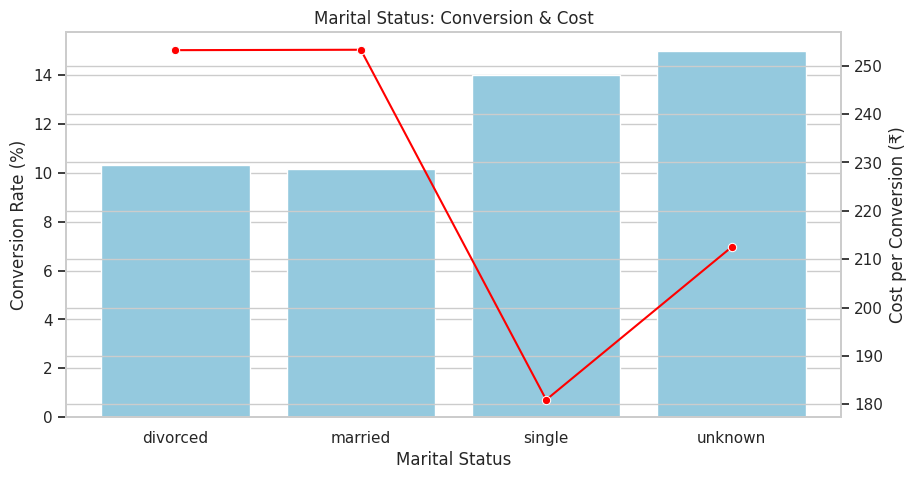

In [ ]:
# visualisation

fig, ax1 = plt.subplots(figsize=(10, 5))
sns.barplot(data=marital_summary, x='marital', y='conversion_rate', ax=ax1, color='skyblue')
ax1.set_ylabel('Conversion Rate (%)')
ax1.set_xlabel('Marital Status')

ax2 = ax1.twinx()
sns.lineplot(data=marital_summary, x='marital', y='cost_per_conversion', ax=ax2, marker='o', color='red')
ax2.set_ylabel('Cost per Conversion (₹)')
plt.title("Marital Status: Conversion & Cost")
plt.show()


In [ ]:
# cost simulation

worst_segment = marital_summary.sort_values('cost_per_conversion', ascending=False).iloc[0]['marital']
df_sim = df[df['marital'] != worst_segment]
total_calls = df_sim['campaign'].sum()
total_conversions = df_sim['y'].sum()
total_cost = total_calls * cost_per_call
cost_per_conv = total_cost / total_conversions

print(f"Removing '{worst_segment}' saves cost per conversion: ₹{cost_per_conv:.2f}")


Removing 'married' saves cost per conversion: ₹197.43


## age

In [ ]:
# insight generation

age_summary = df.groupby('age_bin').agg(
    total_customers=('y', 'count'),
    conversions=('y', 'sum'),
    avg_calls=('campaign', 'mean')
).reset_index()

age_summary['conversion_rate'] = (age_summary['conversions'] / age_summary['total_customers']) * 100
age_summary['total_cost'] = age_summary['total_customers'] * age_summary['avg_calls'] * cost_per_call
age_summary['cost_per_conversion'] = age_summary['total_cost'] / age_summary['conversions'].replace(0, np.nan)

age_summary.round(2)


<ipython-input-10-2880393835>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_summary = df.groupby('age_bin').agg(


,age_bin,total_customers,conversions,avg_calls,conversion_rate,total_cost,cost_per_conversion
0,18-30,7350,1110,2.53,15.10,186200.0,167.75
1,31-40,16385,1597,2.55,9.75,417750.0,261.58
2,41-50,10240,837,2.61,8.17,266800.0,318.76
3,51-60,6270,668,2.69,10.65,168410.0,252.11
4,60+,910,414,1.97,45.49,17900.0,43.24


Interpretation

In [ ]:
# Statistical test

contingency = pd.crosstab(df['age_bin'], df['y'])
chi2, p, dof, _ = chi2_contingency(contingency)

print(f"Chi² = {chi2:.2f}, p = {p:.4f}")
print("✅ Significant difference" if p < 0.05 else "❌ Not statistically significant")

Chi² = 1315.39, p = 0.0000
✅ Significant difference


In [ ]:
plt.clf()  # Clears the current figure

<Figure size 640x480 with 0 Axes>

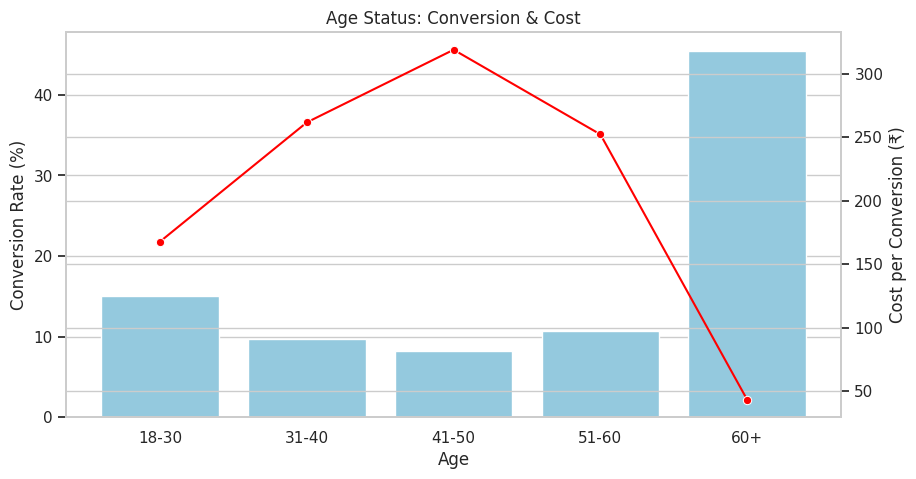

In [ ]:
#  Visualisation

fig, ax1 = plt.subplots(figsize=(10, 5))
sns.barplot(data=age_summary, x='age_bin', y='conversion_rate', ax=ax1, color='skyblue')
ax1.set_ylabel('Conversion Rate (%)')
ax1.set_xlabel('Age')

ax2 = ax1.twinx()
sns.lineplot(data=age_summary, x='age_bin', y='cost_per_conversion', ax=ax2, marker='o', color='red')
ax2.set_ylabel('Cost per Conversion (₹)')
plt.title("Age Status: Conversion & Cost")
plt.show()


## job

In [ ]:
# insight
job_summary = df.groupby('job').agg(
    total_customers=('y', 'count'),
    conversions=('y', 'sum'),
    avg_calls=('campaign', 'mean')
).reset_index()

job_summary['conversion_rate'] = (job_summary['conversions'] / job_summary['total_customers']) * 100
job_summary['total_cost'] = job_summary['total_customers'] * job_summary['avg_calls'] * cost_per_call
job_summary['cost_per_conversion'] = job_summary['total_cost'] / job_summary['conversions'].replace(0, np.nan)

job_summary.round(2)


,job,total_customers,conversions,avg_calls,conversion_rate,total_cost,cost_per_conversion
0,admin.,10422,1352,2.62,12.97,273420.0,202.23
1,blue-collar,9254,638,2.56,6.89,236760.0,371.10
2,entrepreneur,1456,124,2.54,8.52,36920.0,297.74
3,housemaid,1060,106,2.64,10.00,27980.0,263.96
4,management,2924,328,2.48,11.22,72400.0,220.73
5,retired,1720,434,2.48,25.23,42600.0,98.16
6,self-employed,1421,149,2.66,10.49,37810.0,253.76
7,services,3969,323,2.59,8.14,102710.0,317.99
8,student,875,275,2.10,31.43,18410.0,66.95
9,technician,6743,730,2.58,10.83,173790.0,238.07


interpretation

In [ ]:
# stat test

contingency = pd.crosstab(df['job'], df['y'])
chi2, p, dof, _ = chi2_contingency(contingency)

print(f"Chi² = {chi2:.2f}, p = {p:.4f}")
print("✅ Significant difference" if p < 0.05 else "❌ Not statistically significant")

Chi² = 961.24, p = 0.0000
✅ Significant difference


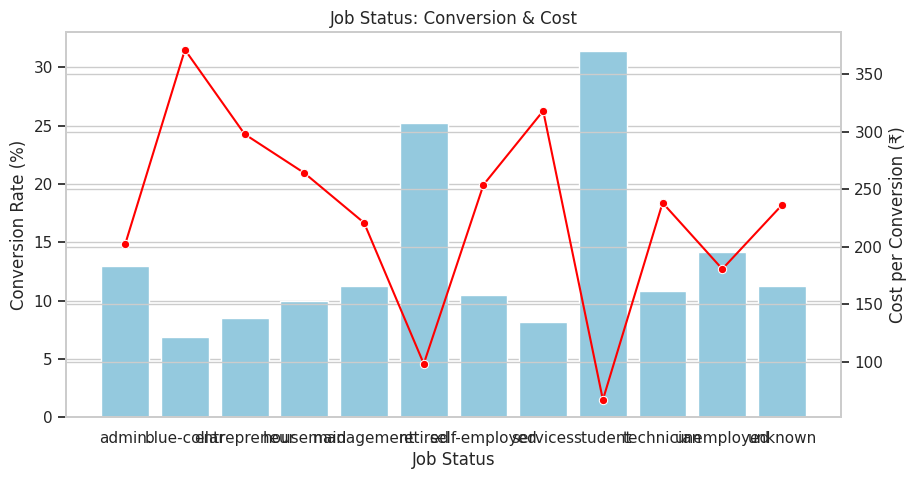

In [ ]:


fig, ax1 = plt.subplots(figsize=(10, 5))
sns.barplot(data=job_summary, x='job', y='conversion_rate', ax=ax1, color='skyblue')
ax1.set_ylabel('Conversion Rate (%)')
ax1.set_xlabel('Job Status')

ax2 = ax1.twinx()
sns.lineplot(data=job_summary, x='job', y='cost_per_conversion', ax=ax2, marker='o', color='red')
ax2.set_ylabel('Cost per Conversion (₹)')
plt.title("Job Status: Conversion & Cost")
plt.show()


In [ ]:
# cost simulation

worst_segment = job_summary.sort_values('cost_per_conversion', ascending=False).iloc[0]['job']
df_sim = df[df['job'] != worst_segment]
total_calls = df_sim['campaign'].sum()
total_conversions = df_sim['y'].sum()
total_cost = total_calls * cost_per_call
cost_per_conv = total_cost / total_conversions

print(f"Removing '{worst_segment}' saves cost per conversion: ₹{cost_per_conv:.2f}")


Removing 'blue-collar' saves cost per conversion: ₹205.09


In [ ]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y', 'age_bin'],
      dtype='object')

## Education

In [ ]:
# insight generation

education_summary = df.groupby('education').agg(
    total_customers=('y', 'count'),
    conversions=('y', 'sum'),
    avg_calls=('campaign', 'mean')
).reset_index()

education_summary['conversion_rate'] = (education_summary['conversions'] / education_summary['total_customers']) * 100
education_summary['total_cost'] = education_summary['total_customers'] * education_summary['avg_calls'] * cost_per_call
education_summary['cost_per_conversion'] = education_summary['total_cost'] / education_summary['conversions'].replace(0, np.nan)

education_summary.round(2)


,education,total_customers,conversions,avg_calls,conversion_rate,total_cost,cost_per_conversion
0,basic.4y,4176,428,2.60,10.25,108600.0,253.74
1,basic.6y,2292,188,2.56,8.20,58590.0,311.65
2,basic.9y,6045,473,2.53,7.82,153080.0,323.64
3,high.school,9515,1031,2.57,10.84,244400.0,237.05
4,illiterate,18,4,2.28,22.22,410.0,102.50
5,professional.course,5243,595,2.59,11.35,135590.0,227.88
6,university.degree,12168,1670,2.56,13.72,311930.0,186.78
7,unknown,1731,251,2.60,14.50,44940.0,179.04


In [ ]:
# statistical Test

contingency = pd.crosstab(df['education'], df['y'])
chi2, p, dof, _ = chi2_contingency(contingency)

print(f"Chi² = {chi2:.2f}, p = {p:.4f}")
print("✅ Significant difference" if p < 0.05 else "❌ Not statistically significant")

Chi² = 193.11, p = 0.0000
✅ Significant difference


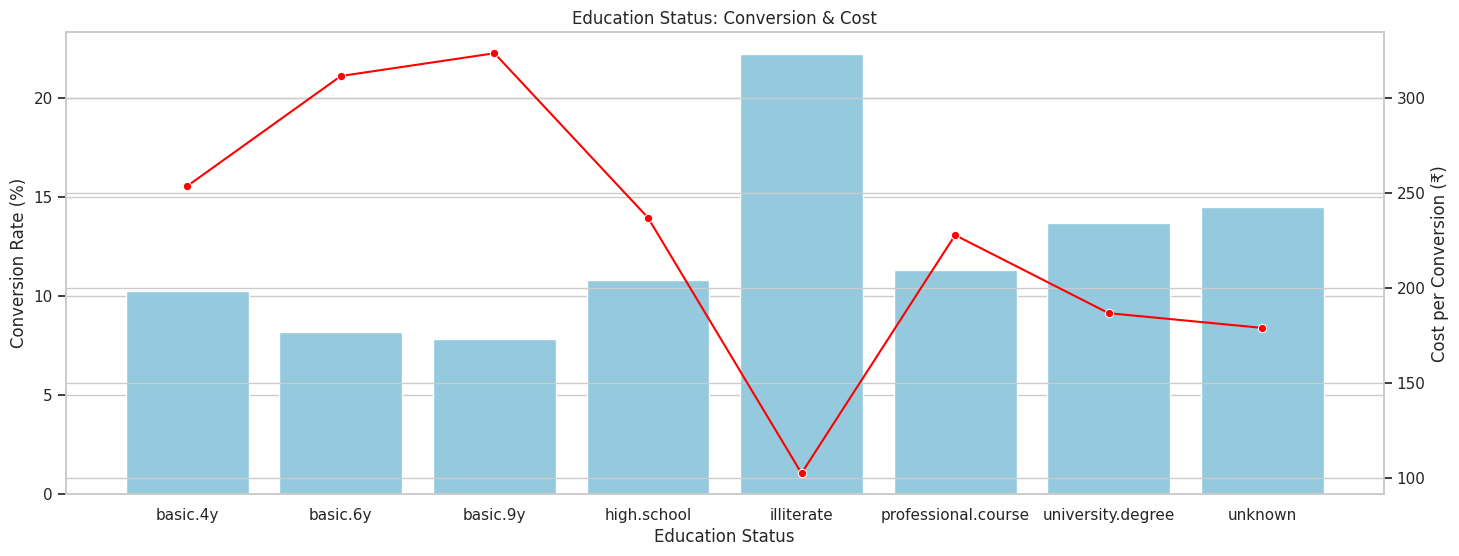

In [ ]:
# visualization

fig, ax1 = plt.subplots(figsize=(17, 6))
sns.barplot(data=education_summary, x='education', y='conversion_rate', ax=ax1, color='skyblue')
ax1.set_ylabel('Conversion Rate (%)')
ax1.set_xlabel('Education Status')

ax2 = ax1.twinx()
sns.lineplot(data=education_summary, x='education', y='cost_per_conversion', ax=ax2, marker='o', color='red')
ax2.set_ylabel('Cost per Conversion (₹)')
plt.title("Education Status: Conversion & Cost")
plt.show()

In [ ]:
# cost simulation

worst_segment = education_summary.sort_values('cost_per_conversion', ascending=False).iloc[0]['education']
df_sim = df[df['education'] != worst_segment]
total_calls = df_sim['campaign'].sum()
total_conversions = df_sim['y'].sum()
total_cost = total_calls * cost_per_call
cost_per_conv = total_cost / total_conversions

print(f"Removing '{worst_segment}' saves cost per conversion: ₹{cost_per_conv:.2f}")

Removing 'basic.9y' saves cost per conversion: ₹217.05


## Default

In [ ]:
# insights

default_summary = df.groupby('default').agg(
    total_customers=('y', 'count'),
    conversions=('y', 'sum'),
    avg_calls=('campaign', 'mean')
).reset_index()

default_summary['conversion_rate'] = (default_summary['conversions'] / default_summary['total_customers']) * 100
default_summary['total_cost'] = default_summary['total_customers'] * default_summary['avg_calls'] * cost_per_call
default_summary['cost_per_conversion'] = default_summary['total_cost'] / default_summary['conversions'].replace(0, np.nan)

default_summary.round(2)

,default,total_customers,conversions,avg_calls,conversion_rate,total_cost,cost_per_conversion
0,no,32588,4197,2.52,12.88,821460.0,195.73
1,unknown,8597,443,2.75,5.15,236040.0,532.82
2,yes,3,0,1.33,0.00,40.0,NaN


In [ ]:
# statistical Test

contingency = pd.crosstab(df['default'], df['y'])
chi2, p, dof, _ = chi2_contingency(contingency)

print(f"Chi² = {chi2:.2f}, p = {p:.4f}")
print("✅ Significant difference" if p < 0.05 else "❌ Not statistically significant")

Chi² = 406.58, p = 0.0000
✅ Significant difference


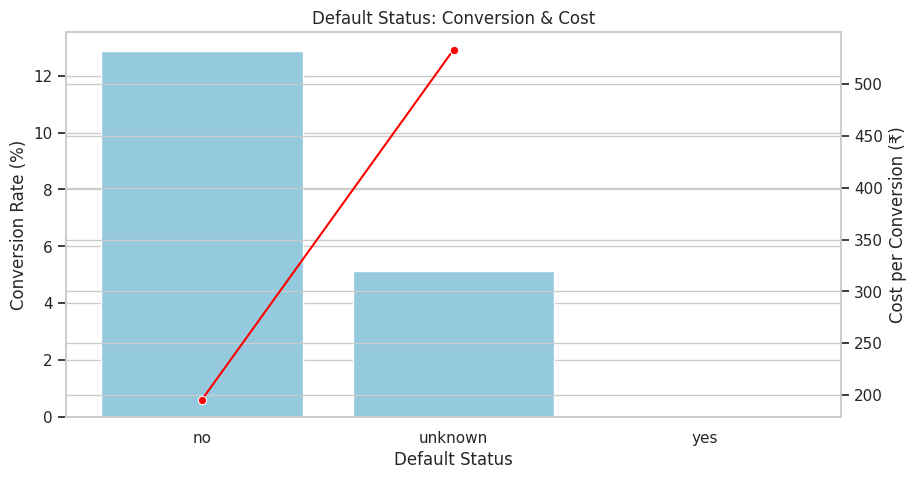

In [ ]:
# visualization

fig, ax1 = plt.subplots(figsize=(10, 5))
sns.barplot(data=default_summary, x='default', y='conversion_rate', ax=ax1, color='skyblue')
ax1.set_ylabel('Conversion Rate (%)')
ax1.set_xlabel('Default Status')

ax2 = ax1.twinx()
sns.lineplot(data=default_summary, x='default', y='cost_per_conversion', ax=ax2, marker='o', color='red')
ax2.set_ylabel('Cost per Conversion (₹)')
plt.title("Default Status: Conversion & Cost")
plt.show()

In [ ]:
# cost simulation
worst_segment = default_summary.sort_values('cost_per_conversion', ascending=False).iloc[0]['default']
df_sim = df[df['default'] != worst_segment]
total_calls = df_sim['campaign'].sum()
total_conversions = df_sim['y'].sum()
total_cost = total_calls * cost_per_call
cost_per_conv = total_cost / total_conversions

print(f"Removing '{worst_segment}' saves cost per conversion: ₹{cost_per_conv:.2f}")

Removing 'unknown' saves cost per conversion: ₹195.74


## Housing

In [ ]:
# insights

house_summary = df.groupby('housing').agg(
    total_customers=('y', 'count'),
    conversions=('y', 'sum'),
    avg_calls=('campaign', 'mean')
).reset_index()

house_summary['conversion_rate'] = (house_summary['conversions'] / house_summary['total_customers']) * 100
house_summary['total_cost'] = house_summary['total_customers'] * house_summary['avg_calls'] * cost_per_call
house_summary['cost_per_conversion'] = house_summary['total_cost'] / house_summary['conversions'].replace(0, np.nan)

house_summary.round(2)

,housing,total_customers,conversions,avg_calls,conversion_rate,total_cost,cost_per_conversion
0,no,18622,2026,2.60,10.88,484360.0,239.07
1,unknown,990,107,2.56,10.81,25350.0,236.92
2,yes,21576,2507,2.54,11.62,547830.0,218.52


In [ ]:
# statistical Test

contingency = pd.crosstab(df['housing'], df['y'])
chi2, p, dof, _ = chi2_contingency(contingency)

print(f"Chi² = {chi2:.2f}, p = {p:.4f}")
print("✅ Significant difference" if p < 0.05 else "❌ Not statistically significant")

Chi² = 5.68, p = 0.0583
❌ Not statistically significant


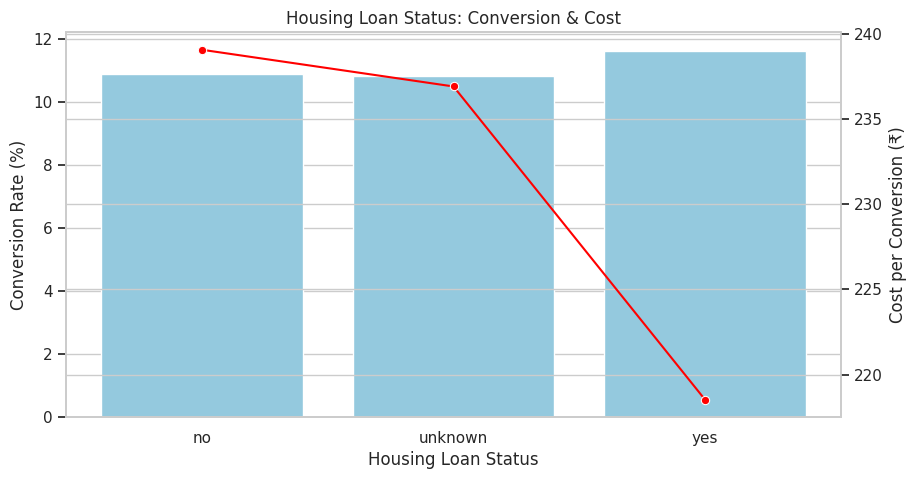

In [ ]:
# visualization

fig, ax1 = plt.subplots(figsize=(10, 5))
sns.barplot(data=house_summary, x='housing', y='conversion_rate', ax=ax1, color='skyblue')
ax1.set_ylabel('Conversion Rate (%)')
ax1.set_xlabel('Housing Loan Status')

ax2 = ax1.twinx()
sns.lineplot(data=house_summary, x='housing', y='cost_per_conversion', ax=ax2, marker='o', color='red')
ax2.set_ylabel('Cost per Conversion (₹)')
plt.title("Housing Loan Status: Conversion & Cost")
plt.show()

In [ ]:
# cost simulation

worst_segment = house_summary.sort_values('cost_per_conversion', ascending=False).iloc[0]['housing']
df_sim = df[df['housing'] != worst_segment]
total_calls = df_sim['campaign'].sum()
total_conversions = df_sim['y'].sum()
total_cost = total_calls * cost_per_call
cost_per_conv = total_cost / total_conversions

print(f"Removing '{worst_segment}' saves cost per conversion: ₹{cost_per_conv:.2f}")

Removing 'no' saves cost per conversion: ₹219.27


## Loan

In [ ]:
# insights

loan_summary = df.groupby('loan').agg(
    total_customers=('y', 'count'),
    conversions=('y', 'sum'),
    avg_calls=('campaign', 'mean')
).reset_index()

loan_summary['conversion_rate'] = (loan_summary['conversions'] / loan_summary['total_customers']) * 100
loan_summary['total_cost'] = loan_summary['total_customers'] * loan_summary['avg_calls'] * cost_per_call
loan_summary['cost_per_conversion'] = loan_summary['total_cost'] / loan_summary['conversions'].replace(0, np.nan)

loan_summary.round(2)

,loan,total_customers,conversions,avg_calls,conversion_rate,total_cost,cost_per_conversion
0,no,33950,3850,2.56,11.34,869600.0,225.87
1,unknown,990,107,2.56,10.81,25350.0,236.92
2,yes,6248,683,2.60,10.93,162590.0,238.05


In [ ]:
# statistical Test

contingency = pd.crosstab(df['loan'], df['y'])
chi2, p, dof, _ = chi2_contingency(contingency)

print(f"Chi² = {chi2:.2f}, p = {p:.4f}")
print("✅ Significant difference" if p < 0.05 else "❌ Not statistically significant")

Chi² = 1.09, p = 0.5787
❌ Not statistically significant


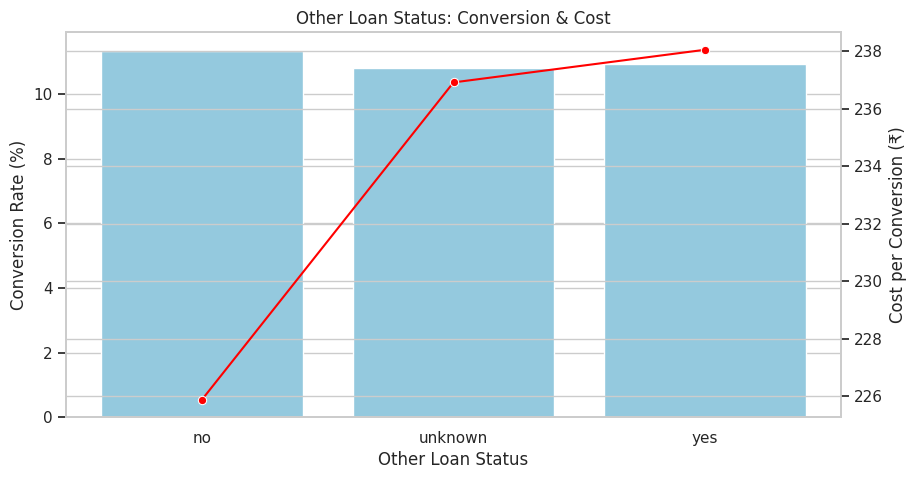

In [ ]:
# visualization

fig, ax1 = plt.subplots(figsize=(10, 5))
sns.barplot(data=loan_summary, x='loan', y='conversion_rate', ax=ax1, color='skyblue')
ax1.set_ylabel('Conversion Rate (%)')
ax1.set_xlabel('Other Loan Status')

ax2 = ax1.twinx()
sns.lineplot(data=loan_summary, x='loan', y='cost_per_conversion', ax=ax2, marker='o', color='red')
ax2.set_ylabel('Cost per Conversion (₹)')
plt.title("Other Loan Status: Conversion & Cost")
plt.show()

In [ ]:
# cost simulation

worst_segment = loan_summary.sort_values('cost_per_conversion', ascending=False).iloc[0]['loan']
df_sim = df[df['loan'] != worst_segment]
total_calls = df_sim['campaign'].sum()
total_conversions = df_sim['y'].sum()
total_cost = total_calls * cost_per_call
cost_per_conv = total_cost / total_conversions

print(f"Removing '{worst_segment}' saves cost per conversion: ₹{cost_per_conv:.2f}")

Removing 'yes' saves cost per conversion: ₹226.17
